In [257]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import xgboost as xgb
import numpy as np

In [258]:
import os
path = os.path.dirname(xgb.__file__)
print(path)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/xgboost


In [259]:
#help(xgboost.training.train)
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of items to be evaluated during training, this allows user to watch
        performance on the validation set.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation error needs to decrease at least
        every **early_stopping_rounds** round(s) to cont

In [260]:
# load data
dataset = loadtxt('data/data.txt', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=8)

In [275]:
dtrain = xgb.DMatrix(data = X_train, label = y_train, silent= True)

deval = xgb.DMatrix(data = X_test, label = y_test, silent= True)
# evals_list = []
# evals_list.append((deval, "eval matrix"))
num_epochs = 500
params = {}
params['num_boost_round'] = num_epochs
params['early_stopping_rounds'] = 1000
#params['verbose_eval'] = 1
params['eval_metric'] = 'logloss'
params['evals_result'] = {}
params['max_depth'] = 3

params['subsample'] = 0.7


In [276]:
learning_rates = []
tresholds = []
learning_rates.append(0.1)
counter = 0
best = []
progress = dict()
wait = []
old_lr = learning_rates[0]
new_lr = learning_rates[0]
def reduceLRonPlateau(i,n):

    factor = 0.3
    min_lr = 1e-30
    min_delta = 1e-4
    patience = 2
    verbose = 0
    cooldown = 3
    cooldown_counter = 0  # Cooldown counter.
    #wait = 0
    #best = 0
    mode = 'min'  
    monitor_op = None
    
    
    def in_cooldown():
            return cooldown_counter > 0
    
    def _reset(mode):
        """Resets wait counter and cooldown counter."""
        if mode not in ['auto', 'min', 'max']:
            warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'
        if (mode == 'min' or
           (mode == 'auto' and 'acc' not in monitor)):
            monitor_op = lambda a, b: np.less(a, b - min_delta)
            best = np.Inf
        else:
            monitor_op = lambda a, b: np.greater(a, b + min_delta)
            best = -np.Inf
            
        cooldown_counter = 0
        del wait[:]
        return wait, cooldown_counter
    
    def checker(wait,best, new_lr, learning_rates):
        if (i == 0):
            wait, counter = _reset(mode)
            print("initialization...")
            print("lr: ", learning_rates[0])
            best.append(100)
            
        if (i>0):
            old_lr = learning_rates[i-1]
        
            #new_lr = learning_rates[i-1]
            current = progress['eval']['logloss'][i-1]
            if in_cooldown():
                cooldown_counter -= 1
                wait = 0
              
            print("iter: ", i, " Current_loss: ", current, "best: ",best[i-1] - min_delta, "less: ",np.less(current, best[i-1] - min_delta))
            if np.less(current, best[i-1] - min_delta):
                
                best.append(current)
                del wait[:]
             
            elif not in_cooldown():
              #  print("not in_cooldown")
                best.append(best[-1])
                wait.append(1)
                if len(wait) >= patience:
                    
                    if old_lr > min_lr:
                        new_lr = old_lr * factor
                        new_lr = max(new_lr, min_lr)
                        print("iter: ", i, "reducing lr -- ", " old_lr: ", old_lr, " new_lr: ", new_lr)
                        
#                         if self.verbose > 0:
#                             print('\nEpoch %05d: ReduceLROnPlateau reducing '
#                                   'learning rate to %s.' % (epoch + 1, new_lr))
                        cooldown_counter = cooldown
                        del wait[:]
                    else:
                        new_lr = old_lr
        return new_lr


       # print("step ",progress['train']['logloss'][i-1], "i = ", i)

            
    new_lr = learning_rates[i-1]
    new_lr = checker(wait,best,new_lr,learning_rates)
    learning_rates.append(new_lr)
    
        
    return new_lr

In [282]:

def run_gbm(dtrain, dvalid, param, evals_result, learning_rate):
    # check training arguments in param
    n_round = param.get('num_boost_round', 100)
    early_stop = param.get('early_stopping_rounds', 0)
    verbose_eval = param.get('verbose_eval', 5)
    # specify validations set to watch performance
    watchlist = [(dtrain,'train') ,(deval,'eval')]
    #callbacks_list = [learning_rates]

    bst = xgb.train(params=param,
            dtrain=dtrain,
            num_boost_round=n_round,
            evals=watchlist,
            early_stopping_rounds=early_stop,
            verbose_eval = verbose_eval,
            evals_result = evals_result, 
            callbacks = [xgb.callback.reset_learning_rate(reduceLRonPlateau)])
                   
    return bst 

In [283]:
model1 = run_gbm(dtrain, deval, params,progress, learning_rate = 0.1)

initialization...
lr:  0.1
[0]	train-logloss:0.693146	eval-logloss:0.693146
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 1000 rounds.
iter:  1  Current_loss:  0.693146 best:  99.9999 less:  True
iter:  2  Current_loss:  0.662099 best:  0.661491 less:  False
iter:  3  Current_loss:  0.635526 best:  0.635263 less:  False
iter:  3 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  4  Current_loss:  0.627557 best:  0.613748 less:  False
iter:  5  Current_loss:  0.602885 best:  0.591777 less:  False
iter:  5 reducing lr --   old_lr:  0.1  new_lr:  0.03
[5]	train-logloss:0.582094	eval-logloss:0.596992
iter:  6  Current_loss:  0.596992 best:  0.572395 less:  False
iter:  7  Current_loss:  0.578699 best:  0.561965 less:  False
iter:  7 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  8  Current_loss:  0.573216 best:  0.550544 less:  False
iter:  9  Current_loss:  0.560081 best:  0.540796 less:  Fal

iter:  91  Current_loss:  0.578742 best:  0.477711 less:  False
iter:  92  Current_loss:  0.578742 best:  0.477711 less:  False
iter:  92 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  93  Current_loss:  0.578359 best:  0.477711 less:  False
iter:  94  Current_loss:  0.578359 best:  0.477711 less:  False
iter:  94 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  95  Current_loss:  0.578744 best:  0.477711 less:  False
[95]	train-logloss:0.331323	eval-logloss:0.578744
iter:  96  Current_loss:  0.578744 best:  0.477711 less:  False
iter:  96 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  97  Current_loss:  0.577541 best:  0.477711 less:  False
iter:  98  Current_loss:  0.577541 best:  0.477711 less:  False
iter:  98 reducing lr --   old_lr:  0.1  new_lr:  0.03
iter:  99  Current_loss:  0.577414 best:  0.477711 less:  False
iter:  100  Current_loss:  0.577414 best:  0.477711 less:  False
iter:  100 reducing lr --   old_lr:  0.1  new_lr:  0.03
[100]	train-logloss:0.329577	eval

iter:  167  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  168  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  168 reducing lr --   old_lr:  4.304672099999998e-10  new_lr:  1.2914016299999993e-10
iter:  169  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  170  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  170 reducing lr --   old_lr:  1.2914016299999993e-10  new_lr:  3.874204889999998e-11
[170]	train-logloss:0.31787	eval-logloss:0.576522
iter:  171  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  172  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  172 reducing lr --   old_lr:  3.874204889999998e-11  new_lr:  1.1622614669999993e-11
iter:  173  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  174  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  174 reducing lr --   old_lr:  1.1622614669999993e-11  new_lr:  3.4867844009999975e-12
iter:  175  Current_loss:  0.576522 best:  0.477711 less:  Fa

[235]	train-logloss:0.31787	eval-logloss:0.576522
iter:  236  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  236 reducing lr --   old_lr:  7.178979876918513e-28  new_lr:  2.153693963075554e-28
iter:  237  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  238  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  238 reducing lr --   old_lr:  2.153693963075554e-28  new_lr:  6.461081889226662e-29
iter:  239  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  240  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  240 reducing lr --   old_lr:  6.461081889226662e-29  new_lr:  1.9383245667679985e-29
[240]	train-logloss:0.31787	eval-logloss:0.576522
iter:  241  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  242  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  242 reducing lr --   old_lr:  1.9383245667679985e-29  new_lr:  5.814973700303995e-30
iter:  243  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  244  Cu

iter:  339  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  340  Current_loss:  0.576522 best:  0.477711 less:  False
[340]	train-logloss:0.31787	eval-logloss:0.576522
iter:  341  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  342  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  343  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  344  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  345  Current_loss:  0.576522 best:  0.477711 less:  False
[345]	train-logloss:0.31787	eval-logloss:0.576522
iter:  346  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  347  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  348  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  349  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  350  Current_loss:  0.576522 best:  0.477711 less:  False
[350]	train-logloss:0.31787	eval-logloss:0.576522
iter:  351  Current_loss:  0.576522 best:  0.477711 less:  False
iter:

iter:  449  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  450  Current_loss:  0.576522 best:  0.477711 less:  False
[450]	train-logloss:0.31787	eval-logloss:0.576522
iter:  451  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  452  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  453  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  454  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  455  Current_loss:  0.576522 best:  0.477711 less:  False
[455]	train-logloss:0.31787	eval-logloss:0.576522
iter:  456  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  457  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  458  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  459  Current_loss:  0.576522 best:  0.477711 less:  False
iter:  460  Current_loss:  0.576522 best:  0.477711 less:  False
[460]	train-logloss:0.31787	eval-logloss:0.576522
iter:  461  Current_loss:  0.576522 best:  0.477711 less:  False
iter:

In [284]:
# fit model no training data

model = XGBClassifier(n_estimators=num_epochs, learning_rate=0.1, subsample=0.7, eta = 0.2 )

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.2, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

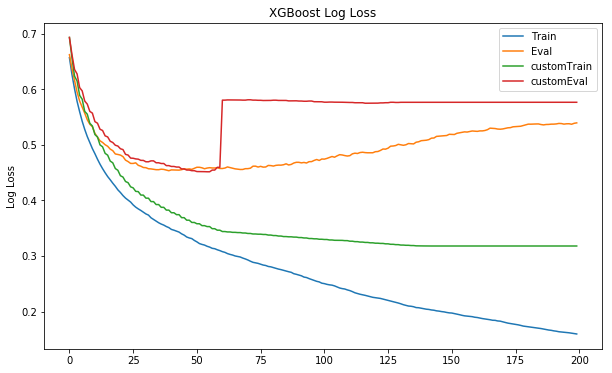

iter:  54  min customEval: 0.451443
iter:  39  min Eval: 0.453349


In [285]:
# retrieve performance metrics
results = model.evals_result()
#results1 = model1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, 200)

# plot log loss
fig, ax = pyplot.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['logloss'][:200:], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'][:200:], label='Eval')
ax.plot(x_axis, progress['train']['logloss'][:200:], label = 'customTrain')
ax.plot(x_axis, progress['eval']['logloss'][:200:], label = 'customEval')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')

pyplot.show()
print("iter: ", progress['eval']['logloss'][:200:].index(min(progress['eval']['logloss'][:200:])), " min customEval:", min(progress['eval']['logloss'][:100:]))
print("iter: ", results['validation_1']['logloss'][:200:].index(min(results['validation_1']['logloss'][:200:])), " min Eval:", min(results['validation_1']['logloss'][:100:]))

In [286]:
# plot classification error
# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['error'], label='Train')
# ax.plot(x_axis, results['validation_1']['error'], label='Test')
# ax.legend()
# pyplot.ylabel('Classification Error')
# pyplot.title('XGBoost Classification Error')
# pyplot.show()